<a href="https://colab.research.google.com/github/YosriMimouna/ASHRAE---Great-Energy-Predictor-III/blob/master/ASHRAE_Great_Energy_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Data from kaggle 

In [0]:
 !pip install -q kaggle

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yosrimimouna","key":"63008de2f8e2da22d8aadad3b6bb3e34"}'}

In [0]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [0]:
! cp kaggle.json ~/.kaggle/

In [0]:
 ! chmod 600 ~/.kaggle/kaggle.json
 !kaggle competitions download -c ashrae-energy-prediction

  0% 0.00/2.53M [00:00<?, ?B/s]
100% 2.53M/2.53M [00:00<00:00, 83.0MB/s]
 90% 108M/120M [00:00<00:00, 87.6MB/s] 
100% 120M/120M [00:01<00:00, 108MB/s] 
  0% 0.00/1.27M [00:00<?, ?B/s]
100% 1.27M/1.27M [00:00<00:00, 83.8MB/s]
  0% 0.00/44.5k [00:00<?, ?B/s]
100% 44.5k/44.5k [00:00<00:00, 30.4MB/s]
 96% 85.0M/88.4M [00:00<00:00, 131MB/s]
100% 88.4M/88.4M [00:00<00:00, 150MB/s]
 97% 161M/167M [00:01<00:00, 82.7MB/s]
100% 167M/167M [00:01<00:00, 95.7MB/s]


In [0]:
! mkdir ASHRAE
! unzip /content/weather_test.csv.zip -d ASHRAE/
! unzip /content/weather_train.csv.zip -d ASHRAE/
! unzip /content/train.csv.zip -d ASHRAE/
! unzip /content/test.csv.zip -d ASHRAE/
!cp /content/building_metadata.csv ASHRAE/

mkdir: cannot create directory ‘ASHRAE’: File exists
Archive:  /content/weather_test.csv.zip
  inflating: ASHRAE/weather_test.csv  
Archive:  /content/weather_train.csv.zip
  inflating: ASHRAE/weather_train.csv  
Archive:  /content/train.csv.zip
  inflating: ASHRAE/train.csv        
Archive:  /content/test.csv.zip
  inflating: ASHRAE/test.csv         


# Necessary Imports

In [0]:
import numpy as np
import pandas as pd
import scipy.special
import matplotlib.pyplot as plt
import os
import random

In [0]:
from keras.utils import Sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM, Embedding
from keras.optimizers import RMSprop,Adam
import keras.backend as K

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

In [0]:
import warnings
warnings.filterwarnings("ignore")

# Load Data

In [0]:
path_in = './ASHRAE/'
print(os.listdir(path_in))

['building_metadata.csv', 'weather_train.csv', 'train.csv', 'test.csv', 'weather_test.csv']


In [0]:
train_data = pd.read_csv(path_in+'train.csv', parse_dates=['timestamp'])
train_weather = pd.read_csv(path_in+'weather_train.csv', parse_dates=['timestamp'])
building_data = pd.read_csv(path_in+'building_metadata.csv')

In [0]:
df = pd.read_csv('submission-file.csv')

In [65]:
df.shape

(41697601, 2)

In [66]:
df.head()

,row_id,meter_reading
0,0,1.000000
1,1,5.651442
2,2,4.828714
3,3,3.734513
4,4,5.993086


In [67]:
df.tail()

,row_id,meter_reading
41697596,41697596,2887.692383
41697597,41697597,545.414673
41697598,41697598,322.929565
41697599,41697599,280.259949
41697600,41697600,256.170898


In [69]:
y_test.shape

(41697601, 1)

# Help function

In [0]:
def plot_bar(data, name):
    fig = plt.figure(figsize=(16, 9))
    ax = fig.add_subplot(111)
    data_label = data[name].value_counts()
    dict_train = dict(zip(data_label.keys(), ((data_label.sort_index())).tolist()))
    names = list(dict_train.keys())
    values = list(dict_train.values())
    plt.bar(names, values)
    ax.set_xticklabels(names, rotation=45)
    plt.grid()
    plt.show()

# Handle missing values of building and weather data
The missing data are numerical values. So for the first step we can use a simple imputer of the sklearn library.

In [0]:
cols_with_missing_train_weather = [col for col in train_weather.columns if train_weather[col].isnull().any()]
cols_with_missing_building = [col for col in building_data.columns if building_data[col].isnull().any()]

In [0]:
print(cols_with_missing_train_weather)
print(cols_with_missing_building)

['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
['year_built', 'floor_count']


In [0]:
imp_most = SimpleImputer(strategy='most_frequent')
train_weather[cols_with_missing_train_weather] = imp_most.fit_transform(train_weather[cols_with_missing_train_weather])
building_data[cols_with_missing_building] = imp_most.fit_transform(building_data[cols_with_missing_building])

# Scale objective label

In [0]:
train_data['meter_reading'] = np.log1p(train_data['meter_reading'])

# Create new features
## Train data
Based on the timestamp we create new features which are cyclic.

In [0]:
train_data['month'] = train_data['timestamp'].dt.month
train_data['day'] = train_data['timestamp'].dt.weekday
train_data['year'] = train_data['timestamp'].dt.year
train_data['hour'] = train_data['timestamp'].dt.hour

Additionally we create the feature weekend: 5 = saturday and 6 = sunday.

In [0]:
train_data['weekend'] = np.where((train_data['day'] == 5) | (train_data['day'] == 6), 1, 0)

## Weather data
The feature wind_direction is cyclic.

In [0]:
train_weather['wind_direction'+'_sin'] = np.sin((2*np.pi*train_weather['wind_direction'])/360)
train_weather['wind_direction'+'_cos'] = np.cos((2*np.pi*train_weather['wind_direction'])/360)
train_weather = train_weather.drop(['wind_direction'], axis=1)

# Encoding
### Feature meter
There are 4 types of meters: <br>
0 = electricity, 1 = chilledwater, 2 = steam, 3 = hotwater <br>
We use the one hot encoding for this 4 feature.

In [0]:
train_data = pd.get_dummies(train_data, columns=['meter'])

### Features month, day and hour
We created the features month, day and hour which are cyclic.

In [0]:
features_cyc = {'month' : 12, 'day' : 7, 'hour' : 24}
for feature in features_cyc.keys():
    train_data[feature+'_sin'] = np.sin((2*np.pi*train_data[feature])/features_cyc[feature])
    train_data[feature+'_cos'] = np.cos((2*np.pi*train_data[feature])/features_cyc[feature])
train_data = train_data.drop(features_cyc.keys(), axis=1)

## Building data
The feature primary_use is a categorical feature with 16 categories. For the first we use a simple mapping.

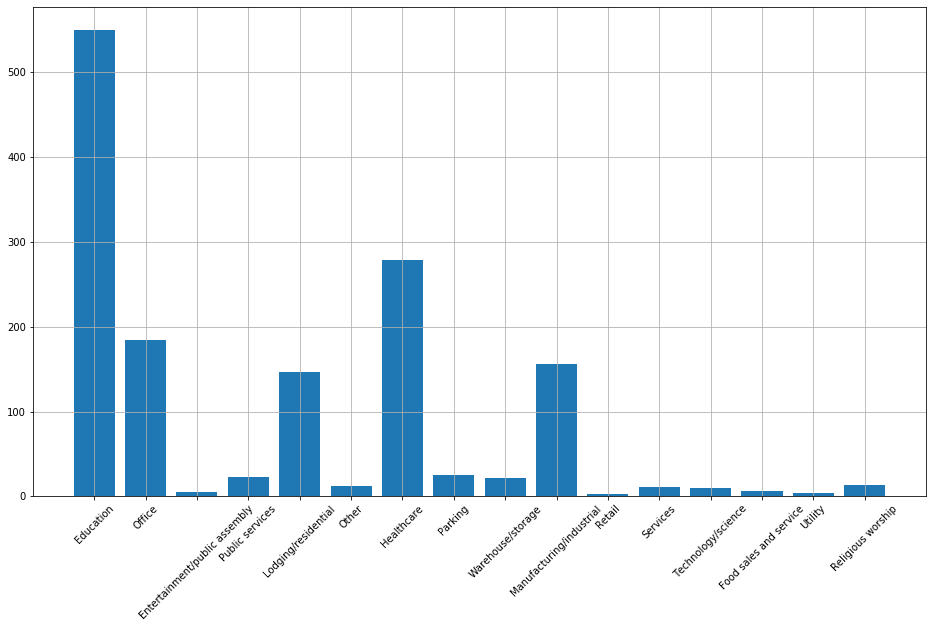

In [0]:
plot_bar(building_data, 'primary_use')

In [0]:
map_use = dict(zip(building_data['primary_use'].value_counts().sort_index().keys(),
                     range(1, len(building_data['primary_use'].value_counts())+1)))

In [0]:
building_data['primary_use'] = building_data['primary_use'].replace(map_use)

In [0]:
#building_data = pd.get_dummies(building_data, columns=['primary_use'])

# Scale building and weather data
## Weather data

In [0]:
weather_scale = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'sea_level_pressure', 'wind_speed']

In [0]:
mean = train_weather[weather_scale].mean(axis=0)
train_weather[weather_scale] = train_weather[weather_scale].astype('float32')
train_weather[weather_scale] -= train_weather[weather_scale].mean(axis=0)
std = train_weather[weather_scale].std(axis=0)
train_weather[weather_scale] /= train_weather[weather_scale].std(axis=0)

## Building data

In [0]:
building_scale = ['square_feet', 'year_built', 'floor_count']

In [0]:
mean = building_data[building_scale].mean(axis=0)
building_data[building_scale] = building_data[building_scale].astype('float32')
building_data[building_scale] -= building_data[building_scale].mean(axis=0)
std = building_data[building_scale].std(axis=0)
building_data[building_scale] /= building_data[building_scale].std(axis=0)

# Merge data

In [0]:
train_data = pd.merge(train_data, building_data, on='building_id', right_index=True)
train_data = train_data.sort_values(['timestamp'])
train_data = pd.merge_asof(train_data, train_weather, on='timestamp', by='site_id', right_index=True)
del train_weather

# Build the data generator

In [0]:
class DataGenerator(Sequence):
  
    def __init__(self, data, list_IDs, features, batch_size, shuffle=False):
        self.data = data.loc[list_IDs].copy()
        self.list_IDs = list_IDs
        self.features = features
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
    
    
    def __len__(self):
        return int(np.floor(len(self.list_IDs)/self.batch_size))
    
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y
    
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

        
    def __data_generation(self, list_IDs_temp):        
        X = np.empty((len(list_IDs_temp), len(self.features)), dtype=float)
        y = np.empty((len(list_IDs_temp), 1), dtype=float)
        X = self.data.loc[list_IDs_temp, self.features].values
        
        if 'meter_reading' in self.data.columns:
            y = self.data.loc[list_IDs_temp, 'meter_reading'].values
        # reshape
        X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
        return X, y

# Split the random input data into train and validation
Since it's a timeseries problem, we split the train and validation data by timestamp and not with a random split.

In [0]:
train_size = int(len(train_data.index)*0.75)
val_size = len(train_data.index) - train_size
train_list, val_list = train_data.index[0:train_size], train_data.index[train_size:train_size+val_size]
print(train_size, val_size)


15162075 5054025


# Define the features

In [0]:
no_features = ['building_id', 'timestamp', 'meter_reading', 'year']
features = train_data.columns.difference(no_features)

# Define train and validation data via Data Generator

In [0]:
batch_size = 1024
train_generator = DataGenerator(train_data, train_list, features, batch_size)
val_generator = DataGenerator(train_data, val_list, features, batch_size)

# Define Recurrent Neural Network
We use a simple recurrent neural network for train and prediction. Later we will improve.

In [0]:
input_dim = len(features)
print(input_dim)

24


In [0]:
model = Sequential()
model.add(LSTM(units=8, activation = 'relu', input_shape=(1, input_dim)))
model.add(Dense(1, activation='relu'))

In [0]:
# Root mean squared error
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [0]:
model.compile(optimizer = Adam(lr=1e-4),
              loss='mse',
              metrics=[rmse])

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 8)                 1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,065
Trainable params: 1,065
Non-trainable params: 0
_________________________________________________________________


In [0]:
epochs = 1

# Train model

In [43]:
history = model.fit_generator(generator=train_generator,
                              validation_data=val_generator,
                              epochs = epochs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/1





14806/14806 [==============================] - 8584s 580ms/step - loss: 5.1912 - rmse: 2.2055 - val_loss: 3.3179 - val_rmse: 1.8169


# Analyse results
A short analysis of the train results.

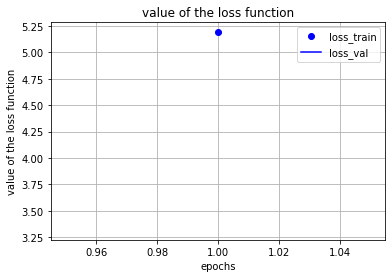

In [45]:
loss = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

In [0]:
acc = history.history['rmse']
acc_val = history.history['val_rmse']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

# Predict test data
* We follow the steps above to prepare the data
* Build data generator
* Predict subdate
* Write data in an array

In [58]:
nrows = 1667904
batch_size = 1022
steps = 25
y_test = np.empty(())
test_weather = pd.read_csv(path_in+'weather_test.csv', parse_dates=['timestamp'])
cols_with_missing_test_weather = [col for col in test_weather.columns if test_weather[col].isnull().any()]
test_weather[cols_with_missing_test_weather] = imp_most.fit_transform(test_weather[cols_with_missing_test_weather])

mean = test_weather[weather_scale].mean(axis=0)
test_weather[weather_scale] = test_weather[weather_scale].astype('float32')
test_weather[weather_scale] -= test_weather[weather_scale].mean(axis=0)
std = test_weather[weather_scale].std(axis=0)
test_weather[weather_scale] /= test_weather[weather_scale].std(axis=0)

test_weather['wind_direction'+'_sin'] = np.sin((2*np.pi*test_weather['wind_direction'])/360)
test_weather['wind_direction'+'_cos'] = np.cos((2*np.pi*test_weather['wind_direction'])/360)
test_weather = test_weather.drop(['wind_direction'], axis=1)

for i in range(0, steps):
    print('work on step ', (i+1))
    test_data = pd.read_csv(path_in+'test.csv', skiprows=range(1,i*(nrows)+1), nrows=nrows, parse_dates=['timestamp'])
    test_data['month'] = test_data['timestamp'].dt.month
    test_data['day'] = test_data['timestamp'].dt.weekday
    test_data['year'] = test_data['timestamp'].dt.year
    test_data['hour'] = test_data['timestamp'].dt.hour
    test_data['weekend'] = np.where((test_data['day'] == 5) | (test_data['day'] == 6), 1, 0)
    for feature in features_cyc.keys():
        test_data[feature+'_sin'] = np.sin((2*np.pi*test_data[feature])/features_cyc[feature])
        test_data[feature+'_cos'] = np.cos((2*np.pi*test_data[feature])/features_cyc[feature])
    test_data = test_data.drop(features_cyc.keys(), axis=1)
    test_data = pd.get_dummies(test_data, columns=['meter'])
    test_data = pd.merge(test_data, building_data, on='building_id', right_index=True)
    test_data = test_data.sort_values(['timestamp'])
    test_data = pd.merge_asof(test_data, test_weather, on='timestamp', by='site_id', right_index=True)
    test_data = test_data.sort_values(['row_id'])
    for feature in features:
        if feature not in test_data:
            test_data[feature] = 0
    test_generator = DataGenerator(test_data, test_data.index, features, batch_size)
    predict = model.predict_generator(test_generator, verbose=1, workers=1)
    predict = np.expm1(predict)
    y_test = np.vstack((y_test, predict))
    del test_data
    del test_generator

work on step  1
1632/1632 [==============================] - 130s 80ms/step
work on step  2
1632/1632 [==============================] - 127s 78ms/step
work on step  3
1632/1632 [==============================] - 136s 83ms/step
work on step  4
1632/1632 [==============================] - 133s 81ms/step
work on step  5
1632/1632 [==============================] - 131s 80ms/step
work on step  6
1632/1632 [==============================] - 127s 78ms/step
work on step  7
1632/1632 [==============================] - 143s 87ms/step
work on step  8
1632/1632 [==============================] - 147s 90ms/step
work on step  9
1632/1632 [==============================] - 149s 91ms/step
work on step  10
1632/1632 [==============================] - 132s 81ms/step
work on step  11
1632/1632 [==============================] - 126s 77ms/step
work on step  12
1632/1632 [==============================] - 128s 79ms/step
work on step  13
1632/1632 [==============================] - 134s 82ms/step
work on 

# Write output for submission

In [0]:
output = pd.DataFrame({'row_id': range(0, len(y_test)),
                       'meter_reading': y_test.reshape(len(y_test))})
output = output[['row_id', 'meter_reading']]
output.to_csv('submission-file.csv', index=False)

In [88]:
!kaggle competitions submit ashrae-energy-prediction -f submission-file.csv -m 'Final submission'

100% 1.04G/1.04G [00:30<00:00, 36.2MB/s]
Successfully submitted to ASHRAE - Great Energy Predictor III